In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os
from tqdm import tqdm
import warnings
import seaborn as sns
import numpy as np
import time
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Conv2D,BatchNormalization,ReLU,LeakyReLU,Add,Activation
from tensorflow.keras.layers import GlobalAveragePooling2D,AveragePooling2D
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
print("\n... IMPORTS STARTING ...\n")

# JUUUUUST IN CASE
import os
os.environ["TF_GPU_ALLOCATOR"]="cuda_malloc_async"

print("\n\tVERSION INFORMATION")
# Machine Learning and Data Science Imports
import tensorflow as tf; print(f"\t\t– TENSORFLOW VERSION: {tf.__version__}");
import tensorflow_hub as tfhub; print(f"\t\t– TENSORFLOW HUB VERSION: {tfhub.__version__}");


import numpy as np; print(f"\t\t– NUMPY VERSION: {np.__version__}");
import sklearn; print(f"\t\t– SKLEARN VERSION: {sklearn.__version__}");
from sklearn.preprocessing import RobustScaler, PolynomialFeatures

from sklearn.model_selection import GroupKFold, StratifiedKFold

# # RAPIDS
# import cudf, cupy, cuml
# from cuml.neighbors import NearestNeighbors
# from cuml.manifold import TSNE, UMAP

# Built In Imports
from kaggle_datasets import KaggleDatasets
from collections import Counter
from datetime import datetime
from glob import glob
import warnings
import requests
import hashlib
import imageio
import IPython
import sklearn
import urllib
import zipfile
import pickle
import random
import shutil
import string
import json
import math
import time
import gzip
import ast
import sys
import io
import os
import gc
import re

# Visualization Imports
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle
import matplotlib.patches as patches
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm; tqdm.pandas();
import plotly.express as px
import seaborn as sns
from PIL import Image, ImageEnhance
import matplotlib; print(f"\t\t– MATPLOTLIB VERSION: {matplotlib.__version__}");
from matplotlib import animation, rc; rc('animation', html='jshtml')
import plotly
import PIL
import cv2

import plotly.io as pio

In [22]:
warnings.filterwarnings("ignore")

plt.style.use("seaborn-darkgrid")

sns.set_context("paper", font_scale=1.4)

BATCH_SIZE = 8

id_map = {
    0: (0, 0, 0), # unlabelled
    1: (111, 74,  0), #static
    2: ( 81,  0, 81), #ground
    3: (128, 64,127), #road
    4: (244, 35,232), #sidewalk
    5: (250,170,160), #parking
    6: (230,150,140), #rail track
    7: (70, 70, 70), #building
    8: (102,102,156), #wall
    9: (190,153,153), #fence
    10: (180,165,180), #guard rail
    11: (150,100,100), #bridge
    12: (150,120, 90), #tunnel
    13: (153,153,153), #pole
    14: (153,153,153), #polegroup
    15: (250,170, 30), #traffic light
    16: (220,220,  0), #traffic sign
    17: (107,142, 35), #vegetation
    18: (152,251,152), #terrain
    19: ( 70,130,180), #sky
    20: (220, 20, 60), #person
    21: (255,  0,  0), #rider
    22: (  0,  0,142), #car
    23: (  0,  0, 70), #truck
    24: (  0, 60,100), #bus
    25: (  0,  0, 90), #caravan
    26: (  0,  0,110), #trailer
    27: (  0, 80,100), #train
    28: (  0,  0,230), #motorcycle
    29: (119, 11, 32), #bicycle
    30: (  0,  0,142) #license plate 
}

category_map = {
    0: 0,
    1: 0,
    2: 0,
    3: 1,
    4: 1,
    5: 1,
    6: 1,
    7: 2,
    8: 2,
    9: 2,
    10: 2,
    11: 2,
    12: 2,
    13: 3,
    14: 3,
    15: 3,
    16: 3,
    17: 4,
    18: 4,
    19: 5,
    20: 6,
    21: 6,
    22: 7,
    23: 7,
    24: 7,
    25: 7,
    26: 7,
    27: 7,
    28: 7,
    29: 7,
    30: 7
}

In [23]:
num_classes = len(id_map.keys())
print(num_classes)


31


In [24]:
from PIL import Image
import numpy as np
import os

def preprocess(normalpath,img2path):
    img1=Image.open(normalpath)
    img1 = img1.resize((128, 128))
    img2=Image.open(img2path)
    img2 = img2.convert('RGB')

    img2 = img2.resize((128, 128))
    img1 = np.array(img1) / 255.
    img2 = np.array(img2)
    mask = np.zeros(shape=(img2.shape[0], img2.shape[1]), dtype = np.uint32)
    for row in range(img2.shape[0]):
        for col in range(img2.shape[1]):
            a = img2[row, col, :]
            final_key = None
            final_d = None
            for key, value in id_map.items():
                d = np.sum(np.sqrt(pow(a - value, 2)))
                if final_key == None:
                    final_d = d
                    final_key = key
                elif d < final_d:
                    final_d = d
                    final_key = key
            mask[row, col] = final_key
    mask = np.reshape(mask, (mask.shape[0], mask.shape[1], 1))  
    del img2
    return img1,mask


In [25]:
X_train_128=np.load("/kaggle/input/cityopfinaldeep/X_train_128.npy")
Y_train_128=np.load("/kaggle/input/cityopfinaldeep/Y_train_128.npy")
X_valid_128=np.load("/kaggle/input/cityopfinaldeep/X_valid_128.npy")
Y_valid_128=np.load("/kaggle/input/cityopfinaldeep/Y_valid_128.npy")

In [26]:
print(X_train_128.shape
     )

(2975, 128, 128, 3)


In [27]:
def convolution_block(block_input, num_filters=256, kernel_size=3,
                      dilation_rate=1, padding="same", use_bias=False,):
    """ TBD """
    x = tf.keras.layers.Conv2D(filters=num_filters, 
                               kernel_size=kernel_size, 
                               dilation_rate=dilation_rate, 
                               padding=padding, 
                               use_bias=use_bias, 
                               kernel_initializer=tf.keras.initializers.HeNormal())(block_input)
    x = tf.keras.layers.BatchNormalization()(x)
    return tf.keras.layers.Activation("relu")(x)

In [28]:
def SqueezeAndExcite(inputs, ratio=8):
    init = inputs
    filters = init.shape[-1]
    se_shape = (1, 1, filters)
    
    se = tf.keras.layers.GlobalAveragePooling2D()(init)
    se = tf.keras.layers.Reshape(se_shape)(se)
    se = tf.keras.layers.Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = tf.keras.layers.Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)
    return init*se

In [29]:
def ASPP(inputs):
    """ Image Pooling """
    shape = inputs.shape
    y1 = tf.keras.layers.AveragePooling2D(pool_size=(shape[1], shape[2]))(inputs)
    y1 = tf.keras.layers.Conv2D(256, 1, padding="same", use_bias=False)(y1)
    y1 = tf.keras.layers.BatchNormalization()(y1)
    y1 = tf.keras.layers.Activation("relu")(y1)
    y1 = tf.keras.layers.UpSampling2D((shape[1], shape[2]), interpolation="bilinear")(y1)

    """ 1x1 conv """
    y2 = tf.keras.layers.Conv2D(512, 3, padding="same", use_bias=False)(inputs)
    y2 = tf.keras.layers.BatchNormalization()(y2)
    y2 = tf.keras.layers.Activation("relu")(y2)

    """ 3x3 conv rate=6 """
    y3 = tf.keras.layers.Conv2D(256, 3, padding="same", use_bias=False, dilation_rate=6)(inputs)
    y3 = tf.keras.layers.BatchNormalization()(y3)
    y3 = tf.keras.layers.Activation("relu")(y3)

    """ 3x3 conv rate=12 """
    y4 = tf.keras.layers.Conv2D(512, 4, padding="same", use_bias=False, dilation_rate=12)(inputs)
    y4 = tf.keras.layers.BatchNormalization()(y4)
    y4 = tf.keras.layers.Activation("relu")(y4)

    """ 3x3 conv rate=18 """
    y5 = tf.keras.layers.Conv2D(256, 3, padding="same", use_bias=False, dilation_rate=18)(inputs)
    y5 = tf.keras.layers.BatchNormalization()(y5)
    y5 = tf.keras.layers.Activation("relu")(y5)
    
    """ 3x3 conv rate=24 """
    y6 = tf.keras.layers.Conv2D(256, 3, padding="same", use_bias=False, dilation_rate=24)(inputs)
    y6 = tf.keras.layers.BatchNormalization()(y6)
    y6 = tf.keras.layers.Activation("relu")(y6)
    
    """ 3x3 conv rate=30 """
    y7 = tf.keras.layers.Conv2D(256, 2, padding="same", use_bias=False, dilation_rate=30)(inputs)
    y7 = tf.keras.layers.BatchNormalization()(y7)
    y7 = tf.keras.layers.Activation("relu")(y7)

    y = tf.keras.layers.Concatenate()([y1, y2, y3, y4, y5, y6, y7])
    y = tf.keras.layers.Conv2D(256, 1, padding="same", use_bias=False)(y)
    y = tf.keras.layers.BatchNormalization()(y)
    y = tf.keras.layers.Activation("relu")(y)

    return y


In [33]:
def DilatedSpatialPyramidPooling(dspp_input, high_feat_shape, low_feat_shape):
    x = tf.keras.layers.AveragePooling2D(pool_size=(high_feat_shape[1], high_feat_shape[2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    
    # Get layers to concatenate
    out_pool = tf.keras.layers.UpSampling2D(size=(high_feat_shape[1]//x.shape[1], high_feat_shape[2]//x.shape[2]), interpolation="bilinear")(x)
    _out_layers = [out_pool] + [convolution_block(dspp_input, 256, _k, _d) for _k, _d in zip((1,3,3,3), (1,6,12,18))]
    
    output = convolution_block(tf.keras.layers.Concatenate(axis=-1)(_out_layers), kernel_size=1)

    return output

In [34]:
def DeeplabV3Plus(backbone, low_feat_layer, high_feat_layer, n_classes, weights="imagenet", dropout=0.2):
    
    _inputs = tf.keras.layers.Input(shape=(*IMAGE_SHAPE, 3))
    encoder_bb = backbone(weights=weights, include_top=False, input_tensor=_inputs)
    
    x = encoder_bb.get_layer(high_feat_layer).output
    x = tf.keras.layers.Dropout(dropout)(x)
    x = ASPP(x)    
    
    input_a = tf.keras.layers.UpSampling2D(size=(IMAGE_SHAPE[0]//4//x.shape[1], 
                                                 IMAGE_SHAPE[1]//4//x.shape[2]), 
                                           interpolation="bilinear")(x)
    input_b = encoder_bb.get_layer(low_feat_layer).output
    input_b = tf.keras.layers.Dropout(dropout)(input_b)
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = tf.keras.layers.Concatenate(axis=-1)([input_a, input_b])
    
    x = SqueezeAndExcite(x)
    x = convolution_block(x)
    x = convolution_block(x)
    x = SqueezeAndExcite(x)
    
    x = tf.keras.layers.UpSampling2D(size=(IMAGE_SHAPE[0]//x.shape[1], 
                                           IMAGE_SHAPE[1]//x.shape[2]), 
                                     interpolation="bilinear",)(x)
    x = tf.keras.layers.Dropout(dropout/2)(x)
    _outputs = tf.keras.layers.Conv2D(n_classes, kernel_size=(1, 1), padding="same", activation='softmax')(x)
    return tf.keras.Model(inputs=_inputs, outputs=_outputs)

IMAGE_SHAPE = (128, 128)


In [37]:
BACKBONE = tf.keras.applications.ResNet50
RES_HIGH_FEAT_LAYER = "conv4_block6_2_relu"
RES_LOW_FEAT_LAYER = "conv2_block3_2_relu"
dummy_model = BACKBONE(include_top=False, weights="imagenet", input_shape=(128,128,3))
high_feat_output = dummy_model.get_layer('conv4_block6_2_conv').output if 'conv4_block6_2_conv' in [layer.name for layer in dummy_model.layers] else dummy_model.output
low_feat_output = dummy_model.get_layer('conv2_block3_2_conv').output if 'conv2_block3_2_conv' in [layer.name for layer in dummy_model.layers] else dummy_model.output

In [38]:
dropout_rate = 0.2  # Adjust this based on your model's needs

deeplabv3plus = DeeplabV3Plus(backbone=BACKBONE,
                              low_feat_layer=RES_LOW_FEAT_LAYER, 
                              high_feat_layer=RES_HIGH_FEAT_LAYER, 
                              n_classes=num_classes,
                              weights="imagenet",  # Assuming using pre-trained weights
                              dropout=dropout_rate)

In [39]:
deeplabv3plus.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 134, 134,  │          0 │ input_layer_9[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 64,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 64, 64,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 66, 66,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 32, 32,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 32, 32,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 32, 32,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 32, 32,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 32, 32,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_3_c

 Total params: 15,638,943 (59.66 MB)

 Trainable params: 15,604,159 (59.53 MB)

 Non-trainable params: 34,784 (135.88 KB)

In [46]:
class UpdatedMeanIoU(tf.keras.metrics.MeanIoU):
  def __init__(self,
               y_true=None,
               y_pred=None,
               num_classes=None,
               name=None,
               dtype=None):
    super(UpdatedMeanIoU, self).__init__(num_classes = num_classes,name=name, dtype=dtype)

  def update_state(self, y_true, y_pred, sample_weight=None):
    y_pred = tf.math.argmax(y_pred, axis=-1)
    return super().update_state(y_true, y_pred, sample_weight)

class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, normalpath, img2path, model, **kwargs):
        super().__init__(**kwargs)
        self.normalpath = normalpath
        self.img2path = img2path
        self._model = model  # Ensure the model is passed as a parameter

    def on_epoch_end(self, epoch, logs=None):
        img, mask = preprocess(self.normalpath, self.img2path)  # Updated to use two paths
        img = np.array(img)
        img = np.reshape(img, (1, 128, 128, 3))  # Assuming img1 is a color image
        pred = self.model.predict(img)
        y_pred = tf.math.argmax(pred, axis=-1)
        y_pred = np.array(y_pred)
        y_pred = np.reshape(y_pred, (128, 128))
        
        fig, axes = plt.subplots(nrows=1, ncols=2)
        axes[0].imshow(mask.squeeze(), cmap='plasma')  # Use squeeze to remove single-channel dimension
        axes[0].set_title("Original Mask")
        axes[1].imshow(y_pred, cmap='plasma')
        axes[1].set_title("Predicted Mask")
        plt.tight_layout()
        plt.show()

def plot_history(history):
  fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize=(20, 7))
  # Training
  sns.lineplot(range(1, len(history.history["loss"]) + 1), history.history["loss"], ax = axes[0], label="Training Loss")
  sns.lineplot(range(1, len(history.history["loss"]) + 1), history.history["accuracy"], ax = axes[1], label="Training Accuracy")
  sns.lineplot(range(1, len(history.history["loss"]) + 1), history.history["mean_iou"], ax = axes[2], label="Training Mean IOU")

  # Validation
  sns.lineplot(range(1, len(history.history["loss"]) + 1), history.history["val_loss"], ax = axes[0], label="Validation Loss")
  sns.lineplot(range(1, len(history.history["loss"]) + 1), history.history["val_accuracy"], ax = axes[1], label="Validation Accuracy")
  sns.lineplot(range(1, len(history.history["loss"]) + 1), history.history["val_mean_iou"], ax = axes[2], label="Validation Mean IOU")
  
  axes[0].set_title("Loss Comparison", fontdict = {'fontsize': 15})
  axes[0].set_xlabel("Epoch")
  axes[0].set_ylabel("Loss")

  axes[1].set_title("Accuracy Comparison", fontdict = {'fontsize': 15})
  axes[1].set_xlabel("Epoch")
  axes[1].set_ylabel("Accuracy")

  axes[2].set_title("Mean IOU Comparison", fontdict = {'fontsize': 15})
  axes[2].set_xlabel("Epoch")
  axes[2].set_ylabel("Mean IOU")
  plt.tight_layout()
  plt.show()

In [47]:
deeplabv3plus.compile(loss = "sparse_categorical_crossentropy", optimizer = "adam", metrics = ["accuracy", UpdatedMeanIoU(num_classes=num_classes, name = "mean_iou")])

In [48]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience = 10, restore_best_weights = True)
callback = VizCallback(normalpath="/kaggle/input/cityopfinaldeep/frankfurt_000000_000576_leftImg8bit.png", img2path="/kaggle/input/cityopfinaldeep/frankfurt_000000_000576_gtFine_color.png", model=deeplabv3plus)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'yewalabestesthai.keras', 
    monitor='val_loss', 
    save_best_only=True, 
    verbose=1
)


Epoch 1/100
  1/372 ━━━━━━━━━━━━━━━━━━━━ 8:34:04 83s/step - accuracy: 0.0119 - loss: 3.6169 - mean_iou: 0.0028

I0000 00:00:1717882889.386852     247 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1717882889.489717     247 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.7205 - loss: 1.0761 - mean_iou: 0.1382

W0000 00:00:1717882977.832253     245 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


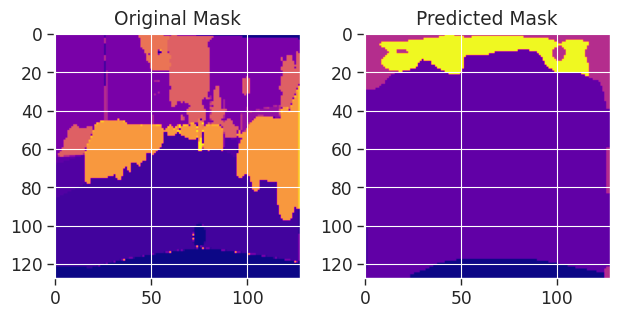


Epoch 1: val_loss improved from inf to 2.52070, saving model to yewalabestesthai.keras
372/372 ━━━━━━━━━━━━━━━━━━━━ 194s 300ms/step - accuracy: 0.7207 - loss: 1.0755 - mean_iou: 0.1382 - val_accuracy: 0.4241 - val_loss: 2.5207 - val_mean_iou: 0.0406
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/stepstep - accuracy: 0.7996 - loss: 0.7155 - mean_iou: 0.207


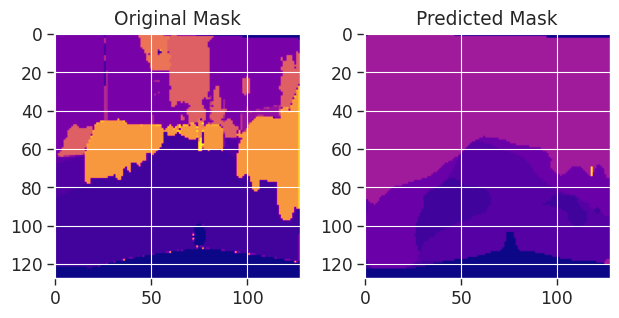


Epoch 2: val_loss improved from 2.52070 to 2.21360, saving model to yewalabestesthai.keras
372/372 ━━━━━━━━━━━━━━━━━━━━ 43s 116ms/step - accuracy: 0.7996 - loss: 0.7154 - mean_iou: 0.2076 - val_accuracy: 0.4165 - val_loss: 2.2136 - val_mean_iou: 0.0516
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/stepstep - accuracy: 0.8080 - loss: 0.6710 - mean_iou: 0.227


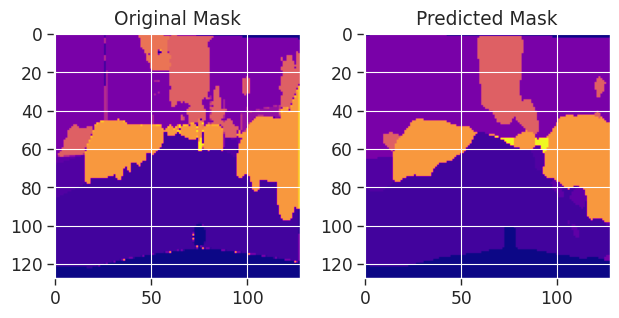


Epoch 3: val_loss improved from 2.21360 to 0.87755, saving model to yewalabestesthai.keras
372/372 ━━━━━━━━━━━━━━━━━━━━ 43s 115ms/step - accuracy: 0.8080 - loss: 0.6710 - mean_iou: 0.2277 - val_accuracy: 0.7433 - val_loss: 0.8776 - val_mean_iou: 0.1685
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/stepstep - accuracy: 0.8179 - loss: 0.6248 - mean_iou: 0.248


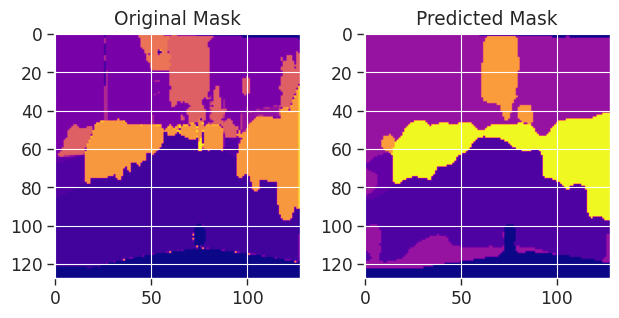


Epoch 4: val_loss did not improve from 0.87755
372/372 ━━━━━━━━━━━━━━━━━━━━ 42s 112ms/step - accuracy: 0.8179 - loss: 0.6248 - mean_iou: 0.2486 - val_accuracy: 0.5542 - val_loss: 1.8369 - val_mean_iou: 0.1335
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/stepstep - accuracy: 0.8244 - loss: 0.5971 - mean_iou: 0.265


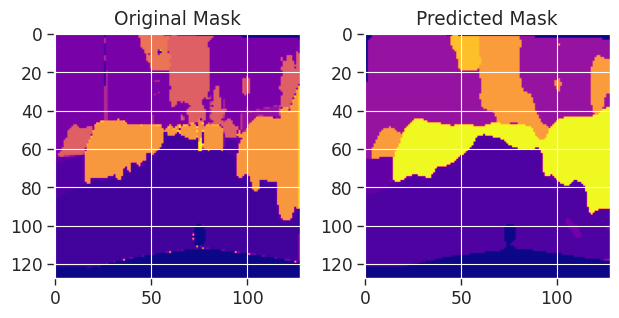


Epoch 5: val_loss improved from 0.87755 to 0.73654, saving model to yewalabestesthai.keras
372/372 ━━━━━━━━━━━━━━━━━━━━ 43s 116ms/step - accuracy: 0.8244 - loss: 0.5971 - mean_iou: 0.2657 - val_accuracy: 0.7866 - val_loss: 0.7365 - val_mean_iou: 0.2133
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/stepstep - accuracy: 0.8290 - loss: 0.5819 - mean_iou: 0.279


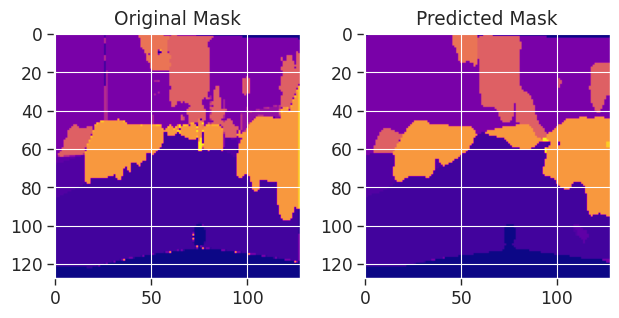


Epoch 6: val_loss did not improve from 0.73654
372/372 ━━━━━━━━━━━━━━━━━━━━ 42s 112ms/step - accuracy: 0.8290 - loss: 0.5819 - mean_iou: 0.2792 - val_accuracy: 0.7693 - val_loss: 0.8017 - val_mean_iou: 0.1935
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/stepstep - accuracy: 0.8367 - loss: 0.5512 - mean_iou: 0.296


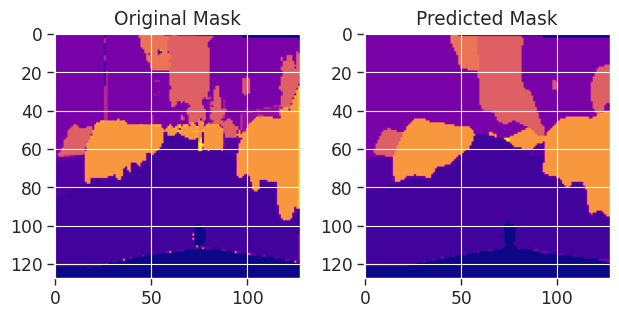


Epoch 7: val_loss did not improve from 0.73654
372/372 ━━━━━━━━━━━━━━━━━━━━ 42s 113ms/step - accuracy: 0.8367 - loss: 0.5512 - mean_iou: 0.2962 - val_accuracy: 0.7762 - val_loss: 0.7986 - val_mean_iou: 0.2077
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/stepstep - accuracy: 0.8380 - loss: 0.5434 - mean_iou: 0.315


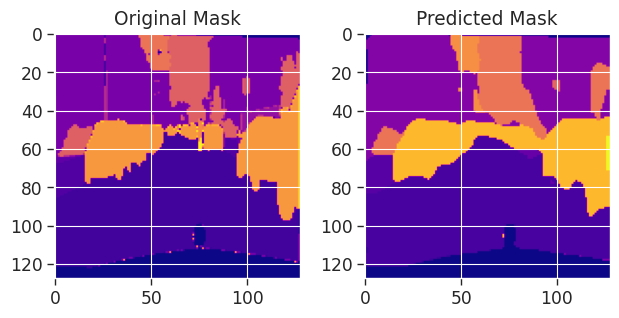


Epoch 8: val_loss improved from 0.73654 to 0.68735, saving model to yewalabestesthai.keras
372/372 ━━━━━━━━━━━━━━━━━━━━ 44s 118ms/step - accuracy: 0.8380 - loss: 0.5434 - mean_iou: 0.3157 - val_accuracy: 0.7964 - val_loss: 0.6874 - val_mean_iou: 0.2382
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/stepstep - accuracy: 0.8487 - loss: 0.5076 - mean_iou: 0.333


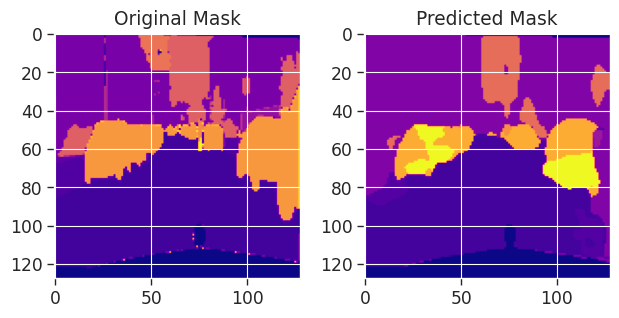


Epoch 9: val_loss did not improve from 0.68735
372/372 ━━━━━━━━━━━━━━━━━━━━ 42s 112ms/step - accuracy: 0.8487 - loss: 0.5076 - mean_iou: 0.3338 - val_accuracy: 0.6774 - val_loss: 1.3260 - val_mean_iou: 0.1697
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/stepstep - accuracy: 0.8474 - loss: 0.5091 - mean_iou: 0.333


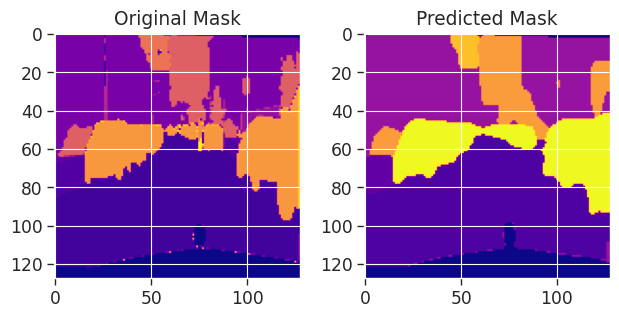


Epoch 10: val_loss did not improve from 0.68735
372/372 ━━━━━━━━━━━━━━━━━━━━ 42s 112ms/step - accuracy: 0.8474 - loss: 0.5091 - mean_iou: 0.3333 - val_accuracy: 0.7945 - val_loss: 0.7049 - val_mean_iou: 0.2307
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/stepstep - accuracy: 0.8491 - loss: 0.5032 - mean_iou: 0.355


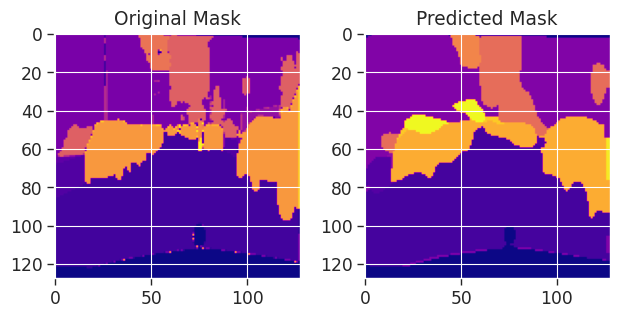


Epoch 11: val_loss did not improve from 0.68735
372/372 ━━━━━━━━━━━━━━━━━━━━ 82s 112ms/step - accuracy: 0.8491 - loss: 0.5032 - mean_iou: 0.3558 - val_accuracy: 0.6681 - val_loss: 1.3412 - val_mean_iou: 0.1776
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/stepstep - accuracy: 0.8534 - loss: 0.4872 - mean_iou: 0.356


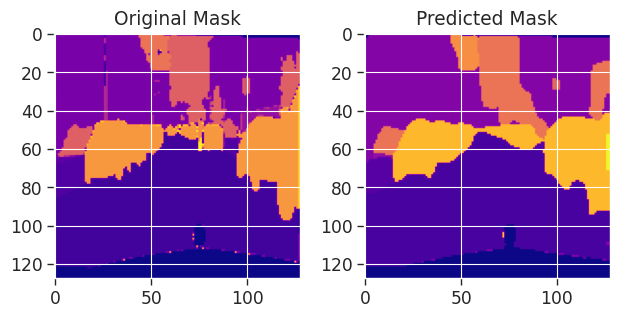


Epoch 12: val_loss improved from 0.68735 to 0.65140, saving model to yewalabestesthai.keras
372/372 ━━━━━━━━━━━━━━━━━━━━ 43s 116ms/step - accuracy: 0.8534 - loss: 0.4872 - mean_iou: 0.3560 - val_accuracy: 0.8157 - val_loss: 0.6514 - val_mean_iou: 0.2596
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/stepstep - accuracy: 0.8607 - loss: 0.4610 - mean_iou: 0.377


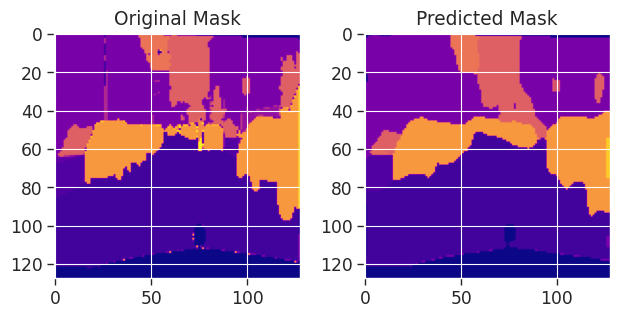


Epoch 13: val_loss did not improve from 0.65140
372/372 ━━━━━━━━━━━━━━━━━━━━ 42s 112ms/step - accuracy: 0.8607 - loss: 0.4610 - mean_iou: 0.3771 - val_accuracy: 0.7945 - val_loss: 0.7957 - val_mean_iou: 0.2372
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/stepstep - accuracy: 0.8614 - loss: 0.4573 - mean_iou: 0.385


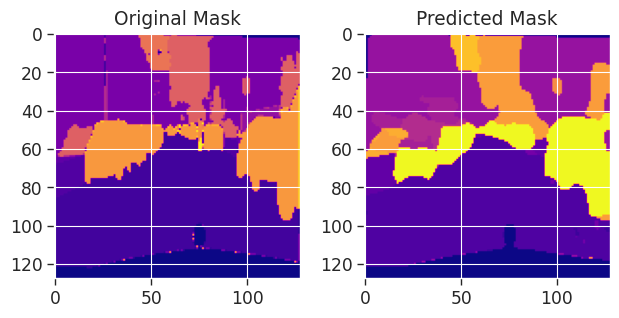


Epoch 14: val_loss did not improve from 0.65140
372/372 ━━━━━━━━━━━━━━━━━━━━ 42s 112ms/step - accuracy: 0.8614 - loss: 0.4573 - mean_iou: 0.3852 - val_accuracy: 0.7928 - val_loss: 0.7242 - val_mean_iou: 0.2468
Epoch 15/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/stepstep - accuracy: 0.8630 - loss: 0.4493 - mean_iou: 0.390


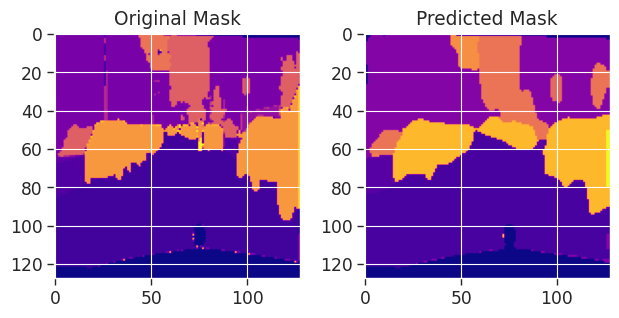


Epoch 15: val_loss did not improve from 0.65140
372/372 ━━━━━━━━━━━━━━━━━━━━ 42s 112ms/step - accuracy: 0.8630 - loss: 0.4493 - mean_iou: 0.3902 - val_accuracy: 0.8003 - val_loss: 0.7479 - val_mean_iou: 0.2491
Epoch 16/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/stepstep - accuracy: 0.8691 - loss: 0.4291 - mean_iou: 0.410


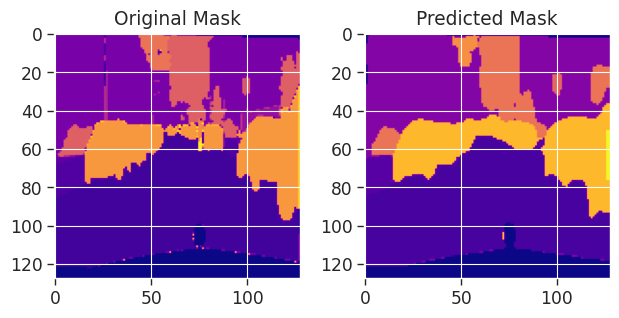


Epoch 16: val_loss did not improve from 0.65140
372/372 ━━━━━━━━━━━━━━━━━━━━ 42s 112ms/step - accuracy: 0.8691 - loss: 0.4291 - mean_iou: 0.4108 - val_accuracy: 0.8132 - val_loss: 0.6746 - val_mean_iou: 0.2508
Epoch 17/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/stepstep - accuracy: 0.8657 - loss: 0.4421 - mean_iou: 0.407


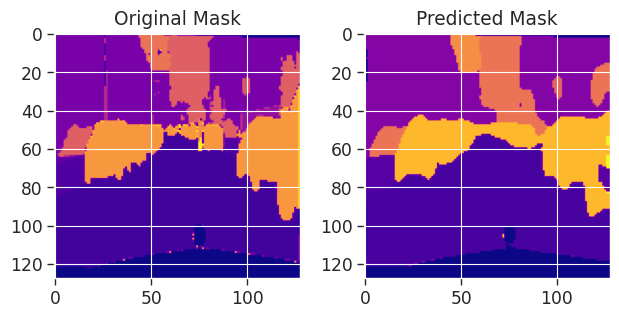


Epoch 17: val_loss did not improve from 0.65140
372/372 ━━━━━━━━━━━━━━━━━━━━ 42s 113ms/step - accuracy: 0.8657 - loss: 0.4421 - mean_iou: 0.4079 - val_accuracy: 0.7841 - val_loss: 0.8543 - val_mean_iou: 0.2224
Epoch 18/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/stepstep - accuracy: 0.8683 - loss: 0.4305 - mean_iou: 0.414


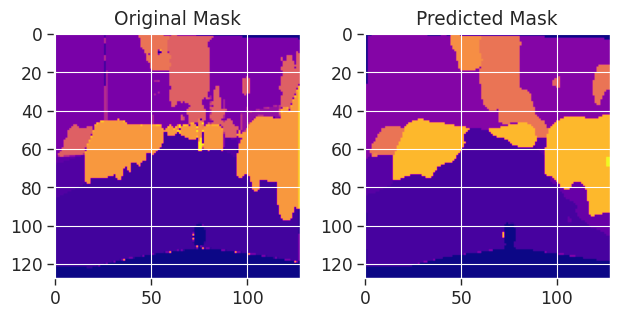


Epoch 18: val_loss did not improve from 0.65140
372/372 ━━━━━━━━━━━━━━━━━━━━ 42s 112ms/step - accuracy: 0.8683 - loss: 0.4306 - mean_iou: 0.4149 - val_accuracy: 0.8049 - val_loss: 0.7281 - val_mean_iou: 0.2490
Epoch 19/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/stepstep - accuracy: 0.8684 - loss: 0.4307 - mean_iou: 0.411


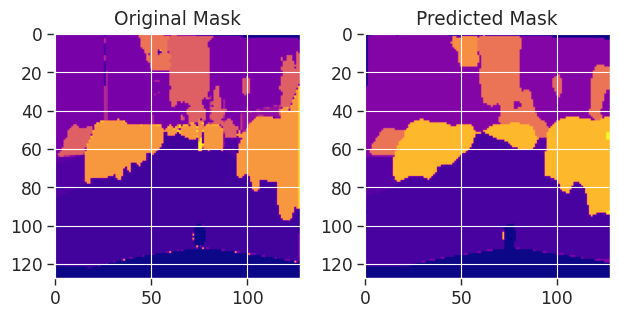


Epoch 19: val_loss did not improve from 0.65140
372/372 ━━━━━━━━━━━━━━━━━━━━ 42s 112ms/step - accuracy: 0.8684 - loss: 0.4307 - mean_iou: 0.4113 - val_accuracy: 0.8120 - val_loss: 0.7277 - val_mean_iou: 0.2520
Epoch 20/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/stepstep - accuracy: 0.8760 - loss: 0.4029 - mean_iou: 0.445


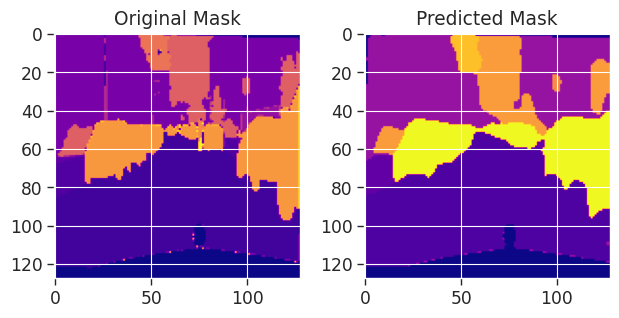


Epoch 20: val_loss did not improve from 0.65140
372/372 ━━━━━━━━━━━━━━━━━━━━ 42s 112ms/step - accuracy: 0.8760 - loss: 0.4029 - mean_iou: 0.4456 - val_accuracy: 0.8160 - val_loss: 0.7118 - val_mean_iou: 0.2511
Epoch 21/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/stepstep - accuracy: 0.8802 - loss: 0.3872 - mean_iou: 0.462


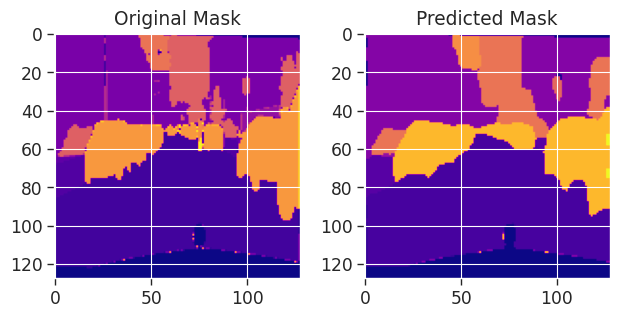


Epoch 21: val_loss did not improve from 0.65140
372/372 ━━━━━━━━━━━━━━━━━━━━ 42s 112ms/step - accuracy: 0.8802 - loss: 0.3872 - mean_iou: 0.4622 - val_accuracy: 0.8125 - val_loss: 0.6973 - val_mean_iou: 0.2609
Epoch 22/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/stepstep - accuracy: 0.8812 - loss: 0.3831 - mean_iou: 0.460


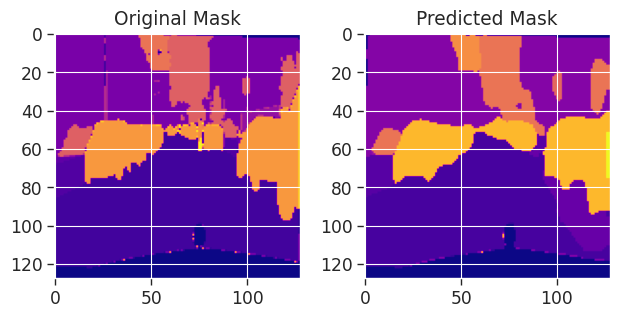


Epoch 22: val_loss did not improve from 0.65140
372/372 ━━━━━━━━━━━━━━━━━━━━ 42s 112ms/step - accuracy: 0.8812 - loss: 0.3831 - mean_iou: 0.4602 - val_accuracy: 0.8189 - val_loss: 0.6840 - val_mean_iou: 0.2647


In [49]:
history = deeplabv3plus.fit(x=X_train_128, y=Y_train_128, epochs = 100, batch_size = BATCH_SIZE, validation_data = (X_valid_128, Y_valid_128), callbacks=[early_stopping, callback,model_checkpoint])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


(-0.5, 127.5, 127.5, -0.5)

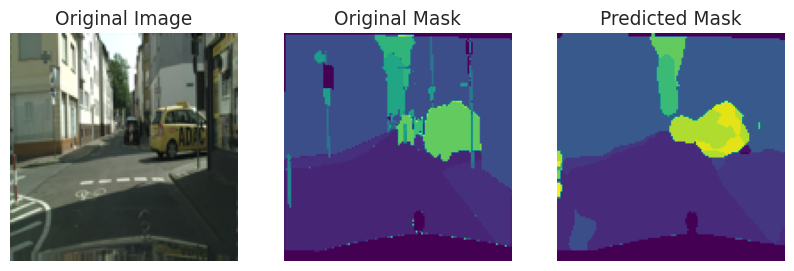

In [51]:
img, mask = preprocess("/kaggle/input/testings/frankfurt_000000_000294_leftImg8bit.png", "/kaggle/input/testings/frankfurt_000000_000294_gtFine_color.png")  # Updated to use two paths

img = np.array(img)
img = np.reshape(img, (1, 128, 128, 3))
pred = deeplabv3plus.predict(img)
y_pred = tf.math.argmax(pred, axis=-1)
y_pred = np.array(y_pred)
y_pred = np.reshape(y_pred, (128, 128))
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize=(10, 5))
img = np.reshape(img, (128, 128, 3))
axes[0].imshow(img)
axes[0].set_title("Original Image")
axes[0].axis("off")
axes[1].imshow(mask, cmap="viridis")
axes[1].set_title("Original Mask")
axes[1].axis("off")
axes[2].imshow(y_pred, cmap="viridis")
axes[2].set_title("Predicted Mask")
axes[2].axis("off")